In [1]:
pwd

'/data2/mito_lineage/notebooks/CHIP_april08_2021_Croker/MTblacklist'

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [3]:
import os
from os.path import join
import pandas as pd
from src.config import RESULTS, FIGURES_DIR, ROOT_DIR
#from src.calculate_AF_by_cell import calculate_af
#ref_fa = "/data2/genome/human_GRCh38/cellranger/refdata-cellranger-GRCh38-3.0.0/fasta/genome.fa"
#ref_fa="/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta"
maxBP = 16571

import glob
import numpy as np

Project Directory: /data2/mito_lineage


In [4]:
from matplotlib_venn import venn2

import seaborn as sns
import matplotlib.pyplot as plt

from mplh import cluster_help

In [5]:
os.chdir(ROOT_DIR)

## Files setup

#### Keep variants greater than mean heteroplasmy minimum parameter 'het'

In [6]:
het = 0.001

In [7]:
samples=["Control", "Flt3l", "Input"]
indir=join(RESULTS,"mttrace")
mapq = "MT"
num_reads = 200
cellr="True"
in_prefix = f'CHIP_april08_2021_Croker/MTblacklist'
filt_id = "minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20"

In [8]:
indirs={}
concat_dirs={}
filter_mgatk_variants = {}
afs={}
mgatk_afs = {}
for s in samples:
    indirs[s] = join(indir, in_prefix, s,mapq,f"cellr_{cellr}")
    concat_dirs[s] = join(indirs[s],f"{s}_{num_reads}")
    filter_mgatk_variants[s] = join(concat_dirs[s], "filters",filt_id,"filter_mgatk")
    afs[s] = pd.read_csv(join(filter_mgatk_variants[s], f"{s}.af.tsv"),sep="\t")
    mgatk_afs[s] = pd.read_csv(join(filter_mgatk_variants[s], f"{s}.af.mgatk.tsv"),sep="\t")
    afs[s] = afs[s].loc[mgatk_afs[s].index]
    print(f"Number of variants after mean heteroplasmy of {het}: {mgatk_afs[s].shape[0]}")

## Add labels to the names
for s in afs:
    afs[s].columns = afs[s].columns + f"_{s}"
all_cells = pd.concat(list(afs.values()), axis=1)

Number of variants after mean heteroplasmy of 0.001: 123
Number of variants after mean heteroplasmy of 0.001: 256
Number of variants after mean heteroplasmy of 0.001: 173


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [9]:
all_cells

,AAACTGCTCTCGCGGA-1_Control,AAAGATGCAGCAACGA-1_Control,AAAGGATGTGCTGTGC-1_Control,AAAGGATTCAAAGTAG-1_Control,AAATGCCCAGAAAGAG-1_Control,AAATGCCGTAAGGTCG-1_Control,AACAAAGAGCGATACG-1_Control,AACAAAGTCAGAGTGG-1_Control,AACAAAGTCTTACGGA-1_Control,AACATCGCATCGAGTT-1_Control,...,TTCGGTCTCTCTTCCT-1_Input,TTGCAGAAGTACGACG-1_Input,TTGCGAACATGGATGG-1_Input,TTGCTATTCCCGTAGG-1_Input,TTGCTTAGTATTCTCT-1_Input,TTGCTTATCGGTTCCT-1_Input,TTGTCTAAGCACGTAG-1_Input,TTTACGTCAGCCACGT-1_Input,TTTGAGGTCTGGGCGT-1_Input,TTTGCGCGTTGAATAG-1_Input
10302A>T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10398A>G,0.0,0.0,0.000000,0.951595,0.0,1.0,0.000000,1.0,0.0,1.0,...,0.00000,0.104439,0.018799,0.000000,0.000000,0.001452,0.458447,0.003831,0.016747,0.000000
103G>A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10400C>T,0.0,0.0,0.000000,0.945312,0.0,1.0,0.000000,1.0,0.0,1.0,...,0.00000,0.108571,0.018930,0.000000,0.000000,0.001550,0.441512,0.004108,0.015044,0.000000
1040T>C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9545A>G,0.0,0.0,0.001871,0.996065,0.0,1.0,0.000000,1.0,0.0,1.0,...,0.00214,0.115965,0.020828,0.000429,0.000000,0.000000,0.465913,0.001287,0.000000,0.000000
9590A>T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9640C>T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983C>T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
variants_set = dict()
for s in mgatk_afs:
    variants_set[s] = mgatk_afs[s].index


## Get type of variant information

In [11]:
import src.utils.variant_utils as vu

In [12]:
variant_df = vu.type_of_variants(all_cells.index.values)
variant_positions = list(map(lambda x: int(x[:-3]), all_cells.index))
variant_df

variants
['10302A>T' '10398A>G' '103G>A' '10400C>T' '1040T>C' '10463T>C' '10516T>A'
 '10559A>G' '10571A>T' '10626T>C' '10646G>A' '10671G>A' '1082A>G'
 '10873T>C' '11137T>C' '11204T>A' '11204T>C' '11238T>C' '11251A>G'
 '11332C>T' '11339T>C' '1134G>A' '11382C>A' '11467A>G' '11655C>G'
 '11684T>C' '11689C>T' '11711G>A' '11719G>A' '1174T>C' '11812A>G'
 '11838T>A' '11914G>A' '1192C>A' '11944T>C' '1199G>T' '12079C>T'
 '12105T>C' '12283G>A' '12283G>T' '12297T>C' '12308A>G' '12372G>A'
 '1252G>A' '12705C>T' '12723A>C' '12723A>G' '12736G>A' '12790T>A'
 '12790T>C' '12913T>C' '1291T>C' '12944T>A' '13042G>A' '13053C>A'
 '13063G>A' '13094T>A' '13108T>A' '13121G>A' '13246T>A' '13246T>C'
 '13263A>G' '13263A>T' '13305C>T' '13339T>A' '1334G>A' '13368G>A'
 '13369T>C' '13422A>T' '13436C>A' '13443T>A' '13443T>C' '13619T>A'
 '13781T>C' '13850A>T' '13931T>C' '14050T>C' '14233A>G' '14274A>G'
 '14318T>C' '14524A>C' '14614A>T' '14620C>T' '146T>C' '1471A>G' '1471A>T'
 '14766C>T' '14783T>C' '14861G>A' '14905G>A' '

,position,ref,alt,variant type,variant change
10302A>T,10302,A,T,Transversion,A>T
10398A>G,10398,A,G,Transition,A>G
103G>A,103,G,A,Transition,G>A
10400C>T,10400,C,T,Transition,C>T
1040T>C,1040,T,C,Transition,T>C
...,...,...,...,...,...
9545A>G,9545,A,G,Transition,A>G
9590A>T,9590,A,T,Transversion,A>T
9640C>T,9640,C,T,Transition,C>T
983C>T,983,C,T,Transition,C>T


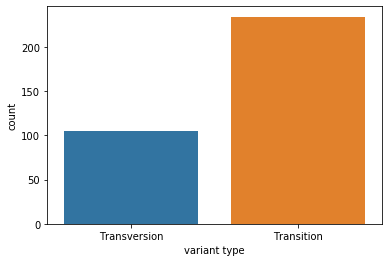

In [13]:
%matplotlib inline
sns.countplot(variant_df["variant type"])

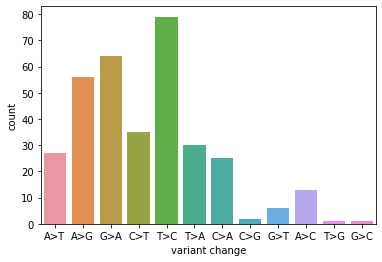

In [14]:
%matplotlib inline
sns.countplot(variant_df["variant change"])

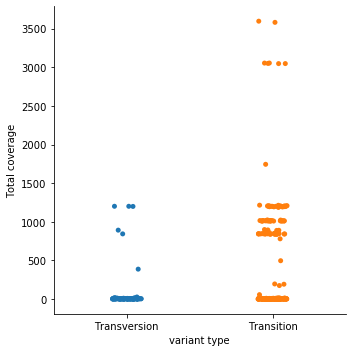

In [15]:
sns.catplot(x="variant type",y="Total coverage",
            data=pd.concat((variant_df,all_cells.fillna(0).sum(axis=1)), axis=1).rename({0:"Total coverage"}, axis=1))

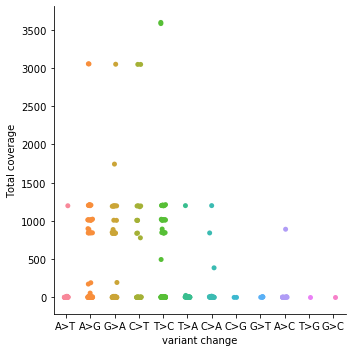

In [16]:
sns.catplot(x="variant change",y="Total coverage",
            data=pd.concat((variant_df,all_cells.sum(axis=1)), axis=1).rename({0:"Total coverage"}, axis=1))

In [24]:
cells_meta = pd.DataFrame([x.split("_")[-1] for x in all_cells.columns], columns=["Condition"],
                         index=all_cells.columns)
cells_meta

,Condition
AAACTGCTCTCGCGGA-1_Control,Control
AAAGATGCAGCAACGA-1_Control,Control
AAAGGATGTGCTGTGC-1_Control,Control
AAAGGATTCAAAGTAG-1_Control,Control
AAATGCCCAGAAAGAG-1_Control,Control
...,...
TTGCTTATCGGTTCCT-1_Input,Input
TTGTCTAAGCACGTAG-1_Input,Input
TTTACGTCAGCCACGT-1_Input,Input
TTTGAGGTCTGGGCGT-1_Input,Input


In [30]:
variant_df

,position,ref,alt,variant type,variant change
10302A>T,10302,A,T,Transversion,A>T
10398A>G,10398,A,G,Transition,A>G
103G>A,103,G,A,Transition,G>A
10400C>T,10400,C,T,Transition,C>T
1040T>C,1040,T,C,Transition,T>C
...,...,...,...,...,...
9545A>G,9545,A,G,Transition,A>G
9590A>T,9590,A,T,Transversion,A>T
9640C>T,9640,C,T,Transition,C>T
983C>T,983,C,T,Transition,C>T


clustering
cmap None


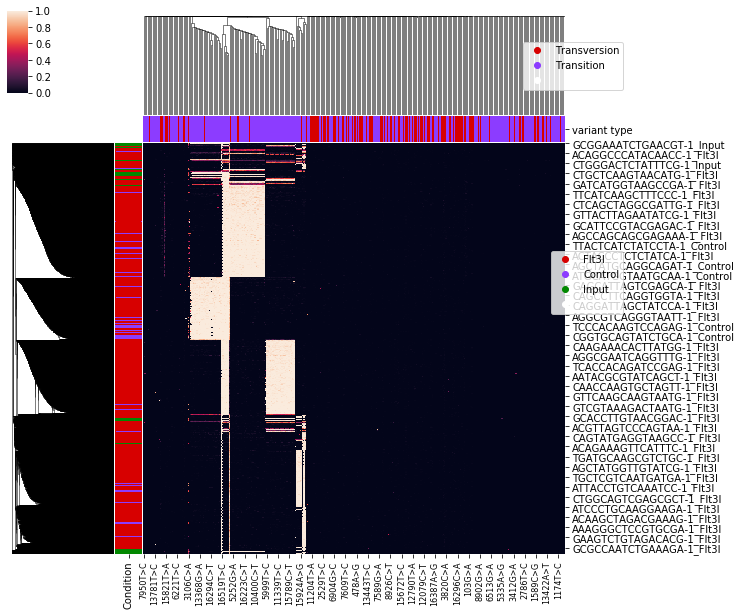

In [31]:
cluster_help.plot_cluster(df=all_cells.fillna(0).transpose(), col_meta=variant_df[["variant type"]],
                 fsave=None, to_z=False, to_col_clust=True, row_meta=cells_meta,
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None, metric='jaccard')

In [33]:
from src.utils.paramspace import Paramspace

In [35]:
join(ROOT_DIR, "parameters", "CHIP_april08_2021", "mttrace.csv")

'/data2/mito_lineage/parameters/CHIP_april08_2021/mttrace.csv'

In [57]:
params_df.columns.drop(['use_cellr_barcode'])

Index(['num_reads_filter', 'base_quality', 'min_cells', 'min_reads', 'topN',
       'het_thresh', 'min_het_cells', 'het_count_thresh', 'bq_thresh',
       'low_cov_thresh', 'n_clone_list'],
      dtype='object')

In [62]:
params_df.columns.drop(['use_cellr_barcode', 'num_reads_filter', 'base_quality']).values

array(['min_cells', 'min_reads', 'topN', 'het_thresh', 'min_het_cells',
       'het_count_thresh', 'bq_thresh', 'low_cov_thresh', 'n_clone_list'],
      dtype=object)

In [65]:
params_df = pd.read_csv(join(ROOT_DIR, "parameters", "CHIP_april08_2021", "mttrace.csv"))
p = Paramspace(params_df, param_sep="__", 
               filename_params=list(params_df.columns.drop(['use_cellr_barcode', 'num_reads_filter', 'base_quality']).values))
p

list(p.instance_patterns)

['use_cellr_barcode__True/num_reads_filter__200/base_quality__20/min_cells__10_min_reads__50_topN__0_het_thresh__0.001_min_het_cells__10_het_count_thresh__5_bq_thresh__20_low_cov_thresh__10_n_clone_list__5;10;20;40;100',
 'use_cellr_barcode__True/num_reads_filter__200/base_quality__20/min_cells__10_min_reads__50_topN__0_het_thresh__0.001_min_het_cells__5_het_count_thresh__2_bq_thresh__20_low_cov_thresh__10_n_clone_list__5;10;20;40;100']